In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns
import plotly.express as px
import json

from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [167]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

In [168]:
# import csv data from data folder
df_main = pd.read_csv('../data/ingresos_membresia_diaria.csv')
df_main.head()

,anio,mes_numero,dia_numero,dia_semana,tipo_suscripcion,id_suscripcion,cantidad_Vendida,ingresos_totales_reales
0,2022,7,25,Monday,1 Día (I.V.A incluido),1,1,$136.88
1,2022,7,27,Wednesday,3 Días (I.V.A incluido),2,1,$234.00
2,2022,7,27,Wednesday,7 Días (I.V.A incluido),3,1,$391.00
3,2022,7,28,Thursday,1 Día (I.V.A incluido),1,3,$354.00
4,2022,7,28,Thursday,Anual (I.V.A incluido),4,1,$521.00


In [169]:
# 2. Crear fecha completa
df_main['fecha'] = pd.to_datetime(df_main[['anio', 'mes_numero', 'dia_numero']].rename(
    columns={'anio': 'year', 'mes_numero': 'month', 'dia_numero': 'day'}
))

# 3. Crear columna de "Inicio de Mes" para agrupar
# Esto convierte '2022-07-25' en '2022-07-01'
df_main['fecha_mes'] = df_main['fecha'].dt.to_period('M').dt.to_timestamp()

print("Datos listos. Muestra de agrupación mensual:")
df_main.head()

Datos listos. Muestra de agrupación mensual:


,anio,mes_numero,dia_numero,dia_semana,tipo_suscripcion,id_suscripcion,cantidad_Vendida,ingresos_totales_reales,fecha,fecha_mes
0,2022,7,25,Monday,1 Día (I.V.A incluido),1,1,$136.88,2022-07-25,2022-07-01
1,2022,7,27,Wednesday,3 Días (I.V.A incluido),2,1,$234.00,2022-07-27,2022-07-01
2,2022,7,27,Wednesday,7 Días (I.V.A incluido),3,1,$391.00,2022-07-27,2022-07-01
3,2022,7,28,Thursday,1 Día (I.V.A incluido),1,3,$354.00,2022-07-28,2022-07-01
4,2022,7,28,Thursday,Anual (I.V.A incluido),4,1,$521.00,2022-07-28,2022-07-01


In [170]:
df_muestra_corte_marzo_2025 = df_main[df_main['fecha_mes'] <= '2025-03-01']
df_muestra_corte_abril_2025 = df_main[df_main['fecha_mes'] <= '2025-04-01']
df_muestra_corte_mayo_2025 = df_main[df_main['fecha_mes'] <= '2025-05-01']
df_muestra_corte_junio_2025 = df_main[df_main['fecha_mes'] <= '2025-06-01']
df_muestra_corte_julio_2025 = df_main[df_main['fecha_mes'] <= '2025-07-01']
df_muestra_corte_agosto_2025 = df_main[df_main['fecha_mes'] <= '2025-08-01']
df_muestra_corte_septiembre_2025 = df_main[df_main['fecha_mes'] <= '2025-09-01']
df_muestra_corte_octubre_2025 = df_main[df_main['fecha_mes'] <= '2025-10-01']
df_muestra_corte_noviembre_2025 = df_main[df_main['fecha_mes'] <= '2025-11-01']
df_muestra_corte_diciembre_2025 = df_main[df_main['fecha_mes'] <= '2025-12-01']

In [171]:
df_main = df_muestra_corte_septiembre_2025

In [172]:
# Agrupamos por Mes y Tipo de Suscripción
df_mensual = df_main.groupby(['fecha_mes', 'tipo_suscripcion'])['ingresos_totales_reales'].sum().reset_index()

print(f"Total de registros mensuales generados: {len(df_mensual)}")
display(df_mensual.head())

Total de registros mensuales generados: 184


,fecha_mes,tipo_suscripcion,ingresos_totales_reales
0,2022-07-01,1 Día (I.V.A incluido),$726.88
1,2022-07-01,3 Días (I.V.A incluido),$234.00
2,2022-07-01,7 Días (I.V.A incluido),$782.00
3,2022-07-01,Anual (I.V.A incluido),"$1,042.00"
4,2022-08-01,1 Día (I.V.A incluido),"$179,596.00"


In [173]:
tipos_suscripcion = df_mensual['tipo_suscripcion'].unique()
meses_a_predecir = 1  # Cambia esto si quieres más meses

# Diccionario para que los meses salgan en español
meses_es = {
    1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril', 5: 'Mayo', 6: 'Junio',
    7: 'Julio', 8: 'Agosto', 9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'
}

print("--- PRONÓSTICO DE VENTAS MENSUAL ---")

# 2. Bucle de Pronóstico e Impresión
for tipo in tipos_suscripcion:
    # Filtrar datos del tipo actual
    df_sub = df_mensual[df_mensual['tipo_suscripcion'] == tipo]
    
    # Crear serie de tiempo mensual
    ts = df_sub.set_index('fecha_mes')['ingresos_totales_reales'].asfreq('MS').fillna(0)
    
    # Solo procesamos si hay datos suficientes (mínimo 12 meses para que sea fiable)
    if len(ts) >= 12:
        try:
            # Seleccionar modelo según cantidad de historia
            if len(ts) >= 24:
                # Si hay >2 años, usamos estacionalidad anual
                modelo = ExponentialSmoothing(ts, seasonal='add', seasonal_periods=12, trend='add', damped_trend=True).fit()
            else:
                # Si hay poco tiempo, solo tendencia
                modelo = ExponentialSmoothing(ts, trend='add').fit()
            
            # Generar pronóstico
            forecast = modelo.forecast(meses_a_predecir)
            
            # --- AQUÍ ESTÁ LA IMPRESIÓN PERSONALIZADA ---
            print(f"\n🔹 {tipo}") # Título de la suscripción
            print("-" * 30)
            
            for fecha, valor in forecast.items():
                nombre_mes = meses_es[fecha.month]
                anio = fecha.year
                # Formato: Mes Año - $Monto (con comas y 2 decimales)
                print(f"{nombre_mes} {anio} - ${valor:,.2f}")
                
        except Exception as e:
            print(f"\n⚠️ No se pudo calcular para {tipo}: Falta historia de datos.")

--- PRONÓSTICO DE VENTAS MENSUAL ---

🔹 1 Día (I.V.A incluido)
------------------------------
Octubre 2025 - $1,237,756.56

🔹 3 Días (I.V.A incluido)
------------------------------
Octubre 2025 - $262,325.14

🔹 7 Días (I.V.A incluido)
------------------------------
Octubre 2025 - $155,697.33

🔹 Anual (I.V.A incluido)
------------------------------
Octubre 2025 - $7,811,014.69

🔹 Anual Ecobici+ (I.V.A incluido)
------------------------------
Octubre 2025 - $118,706.01


No se pudo procesar Membresía Plus TEST 01 (IVA incluido): index 1 is out of bounds for axis 0 with size 1


<Figure size 1500x2800 with 0 Axes>

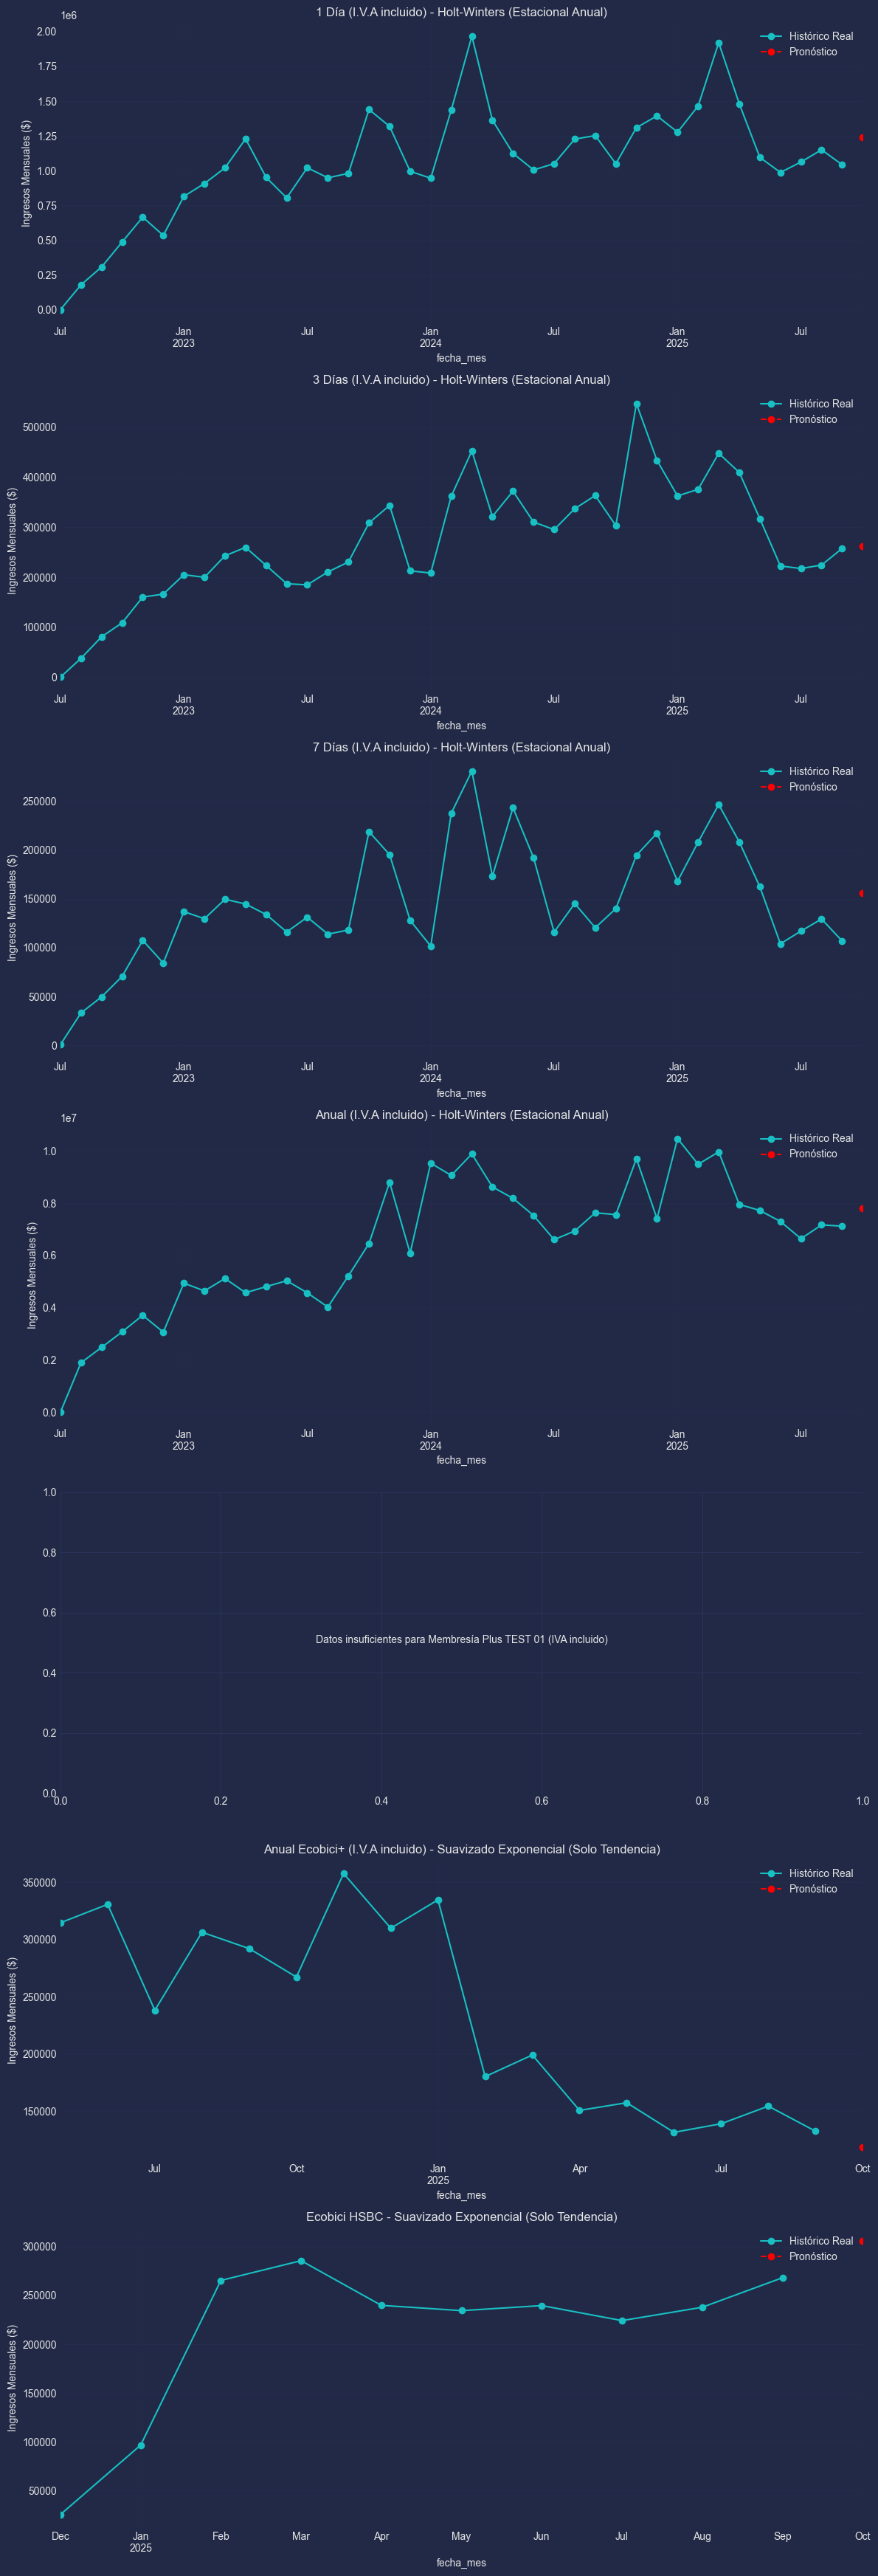

In [174]:
# Pronosticar los próximos 6 meses
resultados_lista = []
plt.figure(figsize=(15, 4 * len(tipos_suscripcion)))

# Crear subgráficos
fig, axes = plt.subplots(nrows=len(tipos_suscripcion), ncols=1, figsize=(12, 5 * len(tipos_suscripcion)))
if len(tipos_suscripcion) == 1: axes = [axes] # Ajuste por si solo hay 1 tipo

for i, tipo in enumerate(tipos_suscripcion):
    ax = axes[i]
    
    # 1. Filtrar datos del tipo actual
    df_sub = df_mensual[df_mensual['tipo_suscripcion'] == tipo]
    
    # 2. Configurar índice y frecuencia mensual ('MS' = Month Start)
    ts = df_sub.set_index('fecha_mes')['ingresos_totales_reales'].asfreq('MS').fillna(0)
    
    try:
        # LÓGICA DE SELECCIÓN DE MODELO
        if len(ts) >= 24:
            # Si hay suficiente historia, buscamos patrones anuales (12 meses)
            modelo = ExponentialSmoothing(
                ts, 
                seasonal='add', 
                seasonal_periods=12, 
                trend='add', 
                damped_trend=True
            ).fit()
            metodo_usado = "Holt-Winters (Estacional Anual)"
        else:
            # Si la historia es corta, solo buscamos tendencia
            modelo = ExponentialSmoothing(ts, trend='add').fit()
            metodo_usado = "Suavizado Exponencial (Solo Tendencia)"

        # 3. Pronosticar
        forecast = modelo.forecast(meses_a_predecir)
        
        # Guardar datos
        total_estimado = forecast.sum()
        resultados_lista.append({
            'Tipo': tipo,
            'Metodo': metodo_usado,
            'Ingreso_Estimado_6Meses': total_estimado
        })
        
        # 4. Graficar
        ts.plot(ax=ax, label='Histórico Real', marker='o')
        forecast.plot(ax=ax, label='Pronóstico', color='red', linestyle='--', marker='o')
        
        ax.set_title(f'{tipo} - {metodo_usado}')
        ax.set_ylabel('Ingresos Mensuales ($)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
    except Exception as e:
        print(f"No se pudo procesar {tipo}: {e}")
        ax.text(0.5, 0.5, f"Datos insuficientes para {tipo}", ha='center')

plt.tight_layout()
plt.show()

In [175]:
# Crear DataFrame de resultados
resumen_df = pd.DataFrame(resultados_lista).sort_values(by='Ingreso_Estimado_6Meses', ascending=False)

# Formato de moneda para visualizar mejor
pd.options.display.float_format = '${:,.2f}'.format

print("\n--- PRONÓSTICO DE INGRESOS (Próximos 6 Meses) ---")
display(resumen_df)


--- PRONÓSTICO DE INGRESOS (Próximos 6 Meses) ---


,Tipo,Metodo,Ingreso_Estimado_6Meses
3,Anual (I.V.A incluido),Holt-Winters (Estacional Anual),"$7,811,014.69"
0,1 Día (I.V.A incluido),Holt-Winters (Estacional Anual),"$1,237,756.56"
5,Ecobici HSBC,Suavizado Exponencial (Solo Tendencia),"$305,752.50"
1,3 Días (I.V.A incluido),Holt-Winters (Estacional Anual),"$262,325.14"
2,7 Días (I.V.A incluido),Holt-Winters (Estacional Anual),"$155,697.33"
4,Anual Ecobici+ (I.V.A incluido),Suavizado Exponencial (Solo Tendencia),"$118,706.01"
